In [1]:
from pyzx.rules import*
import pyzx as zx
import random
from pyzx.graph.base import BaseGraph, VT, ET
from typing import List, Callable, Optional, Union, Generic, Tuple, Dict, Iterator, cast
from typing import TypeVar
from copy import deepcopy

In [2]:
MatchObject = TypeVar("MatchObject")
RewriteOutputType = Tuple[Dict[Tuple[VT,VT],List[int]], List[VT], List[ET], bool]

## Clifford Simp
Clifford_match_functions = [match_ids_parallel, match_spider_parallel, match_pivot_parallel, match_lcomp_parallel]
Clifford_rewrite_functions = [remove_ids, spider, pivot, lcomp]

In [8]:
# ノード及びツリー構造のクラス
class ActionNode:
    def __init__(self,  
    rewrited_graph, applied_match = None, applied_rewrite = None) -> None:
        self.graph = rewrited_graph
        self.applied_match = applied_match
        self.applied_rewrite = applied_rewrite
        self.generation = 0
        self.children = []
    
    def add_childnode(self, childnode):
        self.children.append(childnode)
    
    """def __repr__(self):
        pass"""

class ActionTree:
    def __init__(self, initial_graph) -> None:
        self.root = ActionNode(initial_graph)
        self.current_node = self.root
        self.node_list = [self.root]
    
    def add_action_matches(self, 
        match_functions,
        rewrite_functions,
        node = None):    # current_node, または、指定のノードについて、childnode を作る
        if node is None: node = self.current_node
        
        match_results = search_all_simp_match(node.graph, match_functions)
        if all(not value for value in match_results.values()): # すべてのmatch が空の場合に、ぬける
            return
        
        i = 0
        for key, matches in match_results.items():
            for j in range(len(matches)):
                g1 = deepcopy(node.graph)
                g2 = apply_simp(g1, rewrite_functions[i], [matches[j]])
                new_node = ActionNode(g2, [matches[j]], rewrite_functions[i])
                self.node_list.append(new_node)
                new_node.generation = node.generation + 1
                node.add_childnode(new_node)
            i += 1
    
    def node_generation(self, 
        generation:int):
        same_generation_list = [node for node in self.node_list if node.generation == generation]
        return same_generation_list
    
    # generation を指定し、そのgeneration中の全ノードの子ノードの生成
    def current_child_search(self, generation:int,
        match_functions, 
        rewrite_functions):
        generation_nodelist = self.node_generation(generation)
        for i in range(len(generation_nodelist)):
            self.current_node = generation_nodelist[i]
            self.add_action_matches(match_functions, rewrite_functions)
    
    def show(self, node = None, level = 0):
        if node is None:
            node = self.root
        if node.applied_rewrite == None or node.applied_match == None:
            print("  " * level + f"Generation: {node.generation}, Applied Rewrite: {node.applied_rewrite}, Applied Match: {node.applied_match}")
        else:
            print("  " * level + f"Generation: {node.generation}, Applied Rewrite: {node.applied_rewrite.__name__}, Applied Match: {node.applied_match}")
        for child in node.children:
            self.show(child, level+1)

In [4]:
# クラス外メソッド
def search_all_simp_match(
    g:BaseGraph[VT, ET],
    match_funcions: List[Callable[..., List[MatchObject]]],
) -> Dict[str, List[MatchObject]]:
    all_results = {}
    # Execute match-search methods and store them
    for match_func in match_funcions:
        results = match_func(g)
        all_results[match_func.__name__] = results
    
    # for name, result in all_results.items():
        # print(f"Results for {name}: {result}")
    
    return all_results

def apply_simp(
    g:BaseGraph[VT, ET],
    rewrite_function:Callable[..., List[MatchObject]],
    match:List[MatchObject],
):
    g1 = deepcopy(g)
    etab, rem_verts, rem_edges, check_isolated_vertices = \
    rewrite_function(g,match)
    g1.add_edge_table(etab)
    g1.remove_edges(rem_edges)
    g1.remove_vertices(rem_verts)
    if check_isolated_vertices: g1.remove_isolated_vertices()
    return g1

In [11]:
# 全探索アルゴリズム
def exhaustive_search(
    g:BaseGraph[VT, ET],
    match_functions: List[Callable[..., List[MatchObject]]],
    rewrite_functions: List[Callable[[BaseGraph[VT, ET], List[MatchObject]], RewriteOutputType[VT, ET]]],
):
    action_tree = ActionTree(g)
    generation = 0
    while True:
        action_tree.current_child_search(generation, match_functions, rewrite_functions)
        if action_tree.node_generation(generation+1) == []: break #本番用 世代の全てが空になるまでやる。 
        # if generation == 1: break
        generation += 1
    return action_tree

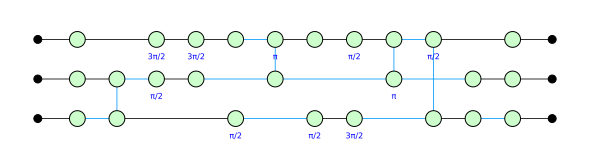

In [9]:
qubit = 3
depth = 10
random.seed(50)
circ = zx.generate.cliffords(qubit, depth)
zx.simplify.to_gh(circ)
zx.draw_matplotlib(circ)

In [12]:
tree = exhaustive_search(circ, Clifford_match_functions, Clifford_rewrite_functions)
tree.show()

KeyboardInterrupt: 